In [1]:
%load_ext autoreload
%autoreload
import inlp_dataset_handler
import inlp
import inlp_linear_model
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression, Ridge, SGDClassifier
from sklearn.svm import LinearSVC, SVR
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

## Classification

In [2]:
x_train, x_dev = np.random.rand(1000,100) - 0.5, np.random.rand(1000,100) - 0.5
y_train, y_dev = np.sum(x_train, axis = 1) > 0, np.sum(x_dev, axis = 1) > 0

inlp_dataset = inlp_dataset_handler.ClassificationDatasetHandler(x_train, y_train, x_dev, y_dev, dropout_rate = 0, Y_train_main = None, Y_dev_main = None, by_class = False, equal_chance_for_main_task_labels = False)

inlp_model_handler = inlp_linear_model.SKlearnClassifier(LinearSVC, {"dual": False})

In [3]:
P, rowspace_projections, Ws = inlp.run_INLP(num_classifiers = 5, input_dim = 100, is_autoregressive = True, min_accuracy = 0, dataset_handler = inlp_dataset, model = inlp_model_handler)

iteration: 4, accuracy: 0.494: 100%|██████████| 5/5 [00:00<00:00, 11.89it/s]


## Sanity checks

In [4]:
def do_sanity_check(P, Ws, x_train):

    assert np.allclose(P.dot(P), P)
    assert np.allclose(Ws[0].dot(P.dot(x_train[0])), 0.0)

    for w in Ws:
        for w2 in Ws:
            if w is w2: continue
            assert np.allclose(w.dot(w2.T).item(), 0.0)
            
do_sanity_check(P, Ws, x_train)

## Siamese

In [5]:
x_train1, x_train2 = np.random.rand(1000,100) - 0.5,  np.random.rand(1000,100) - 0.5,
x_dev1, x_dev2 =  np.random.rand(1000,100) - 0.5, np.random.rand(1000,100) - 0.5

y_train = (np.sign(np.sum(x_train1, axis = 1)) ==  np.sign(np.sum(x_train2, axis = 1))).astype(int)
y_dev = (np.sign(np.sum(x_dev1, axis = 1)) ==  np.sign(np.sum(x_dev2, axis = 1))).astype(int)

inlp_dataset = inlp_dataset_handler.SiameseDatasetHandler((x_train1, x_train2), y_train, (x_dev1, x_dev2), y_dev, dropout_rate = 0, Y_train_main = None, Y_dev_main = None, by_class = False, equal_chance_for_main_task_labels = False)
params = {"num_iter": 25, "input_dim": 100, "hidden_dim": 32, "batch_size": 32, "verbose": False, "device": "cuda",
         "compare_by": "cosine", "same_weights": True}
inlp_model_handler = inlp_linear_model.SiameseLinearClassifier(model_params = params, concat_weights = True)

In [6]:
#inlp_model_handler.train_model(inlp_dataset)
P, rowspace_projections, Ws = inlp.run_INLP(num_classifiers = 3, input_dim = 100, is_autoregressive = True, min_accuracy = 0, dataset_handler = inlp_dataset, model = inlp_model_handler)

  0%|          | 0/3 [00:00<?, ?it/s]INFO:root:         Name               Type Params
0          l1             Linear    3 K
1  cosine_sim   CosineSimilarity    0  
2     loss_fn  BCEWithLogitsLoss    0  
/home/shauli/miniconda3/envs/py3/lib/python3.7/site-packages/pytorch_lightning/callbacks/pt_callbacks.py:250: RuntimeWarning: Can save best model only with val_loss available, skipping.
  ' skipping.', RuntimeWarning)
iteration: 0, accuracy: 0.935546875:  33%|███▎      | 1/3 [00:18<00:37, 18.64s/it]INFO:root:         Name               Type Params
0          l1             Linear    3 K
1  cosine_sim   CosineSimilarity    0  
2     loss_fn  BCEWithLogitsLoss    0  
iteration: 1, accuracy: 0.5146484375:  67%|██████▋   | 2/3 [00:25<00:15, 15.11s/it]INFO:root:         Name               Type Params
0          l1             Linear    3 K
1  cosine_sim   CosineSimilarity    0  
2     loss_fn  BCEWithLogitsLoss    0  
iteration: 2, accuracy: 0.490234375: 100%|██████████| 3/3 [00:32<00:00

## note that the cosine/l2 distance loss is no longer convex, so w_i.dot(w_j) != 0

In [7]:
Ws[0].dot(Ws[1].T)

array([[-0.00931229, -0.00705697, -0.00594046, ..., -0.01173834,
        -0.01026593,  0.00704478],
       [ 0.03257236,  0.02072234,  0.02709211, ...,  0.03719799,
         0.02334654, -0.0207014 ],
       [-0.01444635, -0.01480279, -0.01907747, ..., -0.02516075,
        -0.0153033 ,  0.01085522],
       ...,
       [-0.01069078, -0.00390789, -0.016464  , ..., -0.00865372,
        -0.00920071,  0.0086457 ],
       [-0.03199115, -0.02742783, -0.02059062, ..., -0.047868  ,
        -0.03588128,  0.02623508],
       [ 0.0095946 ,  0.00331805,  0.00982535, ...,  0.0070582 ,
         0.00234786, -0.00445423]])

In [8]:
print(np.linalg.norm(P.dot(P) - P))
print( np.linalg.norm( Ws[-1][:32, :].dot(P.dot(x_train1[0]))) ) # note that the norm is not exactly 0 due to pytorch floating point precision

1.5332055519628136e-14
1.6853091125729208e-13


# Metric Siamese

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle
import random

In [3]:
mnist = fetch_openml('mnist_784')
X,Y = mnist.data, np.array([int(y) for y in mnist.target])
X,Y = shuffle(X,Y)

In [4]:
X /= 255.
pairs = []
ids = []
strs = []
label_set = range(10)
k = 2500

for y in label_set:
    
    idx = Y == y
    relevant = X[idx]
    x1 = relevant[np.random.choice(relevant.shape[0], k, replace=False), :]
    x2 = relevant[np.random.choice(relevant.shape[0], k, replace=False), :]
    tuples = list(zip(x1,x2))
    pairs.extend(tuples)
    ids.extend([y]*k)
    strs.extend([""]*k)
    

In [5]:
data = []
for pair, pair_id, sent in zip(pairs, ids, strs):
    
    data.append({"pair": pair, "pair_id": pair_id, "sent": sent})

In [6]:
random.shuffle(data)
x_train1, x_train2 = [], []
x_dev1, x_dev2 = [], []

sents_train1, sents_train2 = [], []
sents_dev1, sents_dev2 = [], []

ids_train1, ids_train2 = [], []
ids_dev1, ids_dev2 = [], []

l = int(0.8 * len(data))
train, dev = data[:l], data[l:]

for d in train:
        
        x1,x2 = d["pair"]
        id1,id2 = d["pair_id"], d["pair_id"]
        sent1, sent2 = d["sent"], d["sent"]
        
        x_train1.append(x1)
        x_train2.append(x2)
        sents_train1.append(sent1)
        sents_train2.append(sent2)
        ids_train1.append(id1)
        ids_train2.append(id2)
        
for d in dev:
        
        x1,x2 = d["pair"]
        id1,id2 = d["pair_id"], d["pair_id"]
        sent1, sent2 = d["sent"], d["sent"]
        
        x_dev1.append(x1)
        x_dev2.append(x2)
        sents_dev1.append(sent1)
        sents_dev2.append(sent2)
        ids_dev1.append(id1)
        ids_dev2.append(id2)        

In [7]:
x_train1, x_train2, x_dev1, x_dev2 = np.array(x_train1), np.array(x_train2), np.array(x_dev1), np.array(x_dev2)
sents_train1, sents_train2, sents_dev1, sents_dev2 = np.array(sents_train1), np.array(sents_train2), np.array(sents_dev1), np.array(sents_dev2)
ids_train1, ids_train2, ids_dev1, ids_dev2 = np.array(ids_train1), np.array(ids_train2), np.array(ids_dev1), np.array(ids_dev2)

In [8]:
x_train1.shape

(20000, 784)

### INLP

In [9]:
siamese_dataset_handler = inlp_dataset_handler.MetricSiameseDatasetHandler((x_train1, x_train2), (x_dev1, x_dev2), (sents_train1, sents_train2), (ids_train1, ids_train2),(sents_dev1, sents_dev2), (ids_dev1, ids_dev2))

In [21]:
from siamese_model import SiameseMetric
params = {"input_dim": 784, "hidden_dim": 32, "batch_size": 32, "verbose": False,
         "k": 1, "p": 2, "alpha": 0.1, "mode": "euc", "final": "plus", "device": "cpu", "num_iter": 5}
inlp_model_handler = inlp_linear_model.SiameseMetricLearning(model_class = SiameseMetric, model_params = params)

In [25]:
P, rowspace_projections, Ws = inlp.run_INLP(num_classifiers = 10, input_dim = 784, is_autoregressive = True, min_accuracy = 0, dataset_handler = siamese_dataset_handler, model = inlp_model_handler)

  0%|          | 0/10 [00:00<?, ?it/s]INFO:root:      Name                  Type Params
0        l                Linear   25 K
1  loss_fn  BatchHardTripletLoss    0  
Epoch 1:   3%|▎         | 22/782 [00:00<00:08, 89.40batch/s, batch_nb=21, loss=0.637, v_nb=66]

Loss is 1.0512675335535882


Epoch 1: 100%|██████████| 782/782 [00:05<00:00, 245.00batch/s, batch_nb=624, loss=0.142, v_nb=66]
                                                                 /home/shauli/miniconda3/envs/py3/lib/python3.7/site-packages/pytorch_lightning/callbacks/pt_callbacks.py:250: RuntimeWarning: Can save best model only with val_loss available, skipping.
  ' skipping.', RuntimeWarning)
Epoch 2:   3%|▎         | 22/782 [00:00<00:03, 245.00batch/s, batch_nb=21, loss=0.140, v_nb=66]  

Loss is 0.13787581042591743


Epoch 3:   3%|▎         | 20/782 [00:00<00:03, 229.49batch/s, batch_nb=19, loss=0.128, v_nb=66]  

Loss is 0.12753053175874093


Epoch 4:   3%|▎         | 21/782 [00:00<00:03, 200.17batch/s, batch_nb=20, loss=0.138, v_nb=66]  

Loss is 0.13337110651164344


Epoch 5:   2%|▏         | 19/782 [00:00<00:03, 252.19batch/s, batch_nb=18, loss=0.142, v_nb=66]  

Loss is 0.14021725654404463


iteration: 0, accuracy: 0.13647667352947884:   0%|          | 0/10 [00:28<?, ?it/s]

Loss is 0.13647667352947884


iteration: 0, accuracy: 0.13647667352947884:  10%|█         | 1/10 [00:28<04:19, 28.80s/it]INFO:root:      Name                  Type Params
0        l                Linear   25 K
1  loss_fn  BatchHardTripletLoss    0  
Epoch 1:   2%|▏         | 19/782 [00:00<00:08, 89.35batch/s, batch_nb=18, loss=0.612, v_nb=67]

Loss is 0.9509407934606916


Epoch 2:   3%|▎         | 24/782 [00:00<00:02, 258.77batch/s, batch_nb=23, loss=0.138, v_nb=67]  

Loss is 0.13654061734328843


Epoch 3:   3%|▎         | 20/782 [00:00<00:03, 247.09batch/s, batch_nb=19, loss=0.127, v_nb=67]  

Loss is 0.12682487812062807


Epoch 4:   3%|▎         | 23/782 [00:00<00:03, 231.33batch/s, batch_nb=22, loss=0.144, v_nb=67]  

Loss is 0.14769331457921392


Epoch 5:   3%|▎         | 20/782 [00:00<00:03, 236.41batch/s, batch_nb=19, loss=0.134, v_nb=67]  

Loss is 0.13116473623905642


iteration: 1, accuracy: 0.129277581776152:  10%|█         | 1/10 [00:56<04:19, 28.80s/it]  

Loss is 0.129277581776152


iteration: 1, accuracy: 0.129277581776152:  20%|██        | 2/10 [00:57<03:50, 28.77s/it]INFO:root:      Name                  Type Params
0        l                Linear   25 K
1  loss_fn  BatchHardTripletLoss    0  
Epoch 1:   3%|▎         | 23/782 [00:00<00:07, 106.55batch/s, batch_nb=22, loss=0.565, v_nb=68]

Loss is 0.9786949596073237


Epoch 2:   3%|▎         | 21/782 [00:00<00:03, 236.89batch/s, batch_nb=20, loss=0.138, v_nb=68]  

Loss is 0.13790432393255916


Epoch 3:   3%|▎         | 24/782 [00:00<00:03, 203.21batch/s, batch_nb=23, loss=0.136, v_nb=68]  

Loss is 0.13638511364031894


Epoch 4:   3%|▎         | 26/782 [00:00<00:03, 238.46batch/s, batch_nb=25, loss=0.135, v_nb=68]  

Loss is 0.13160226809715272


Epoch 5:   3%|▎         | 25/782 [00:00<00:03, 208.73batch/s, batch_nb=24, loss=0.146, v_nb=68]  

Loss is 0.14749327811501778


iteration: 2, accuracy: 0.14264885285986736:  20%|██        | 2/10 [01:24<03:50, 28.77s/it]

Loss is 0.14264885285986736


iteration: 2, accuracy: 0.14264885285986736:  30%|███       | 3/10 [01:25<03:19, 28.53s/it]INFO:root:      Name                  Type Params
0        l                Linear   25 K
1  loss_fn  BatchHardTripletLoss    0  
Epoch 1:   2%|▏         | 19/782 [00:00<00:08, 84.84batch/s, batch_nb=18, loss=0.599, v_nb=69]

Loss is 1.0219400866742423


Epoch 2:   3%|▎         | 26/782 [00:00<00:03, 191.04batch/s, batch_nb=25, loss=0.139, v_nb=69]  

Loss is 0.13638066297392912


Epoch 3:   3%|▎         | 25/782 [00:00<00:03, 219.68batch/s, batch_nb=24, loss=0.130, v_nb=69]  

Loss is 0.13222548193762118


Epoch 4:   3%|▎         | 23/782 [00:00<00:03, 229.21batch/s, batch_nb=22, loss=0.133, v_nb=69]  

Loss is 0.1323415699157505


Epoch 5:   3%|▎         | 21/782 [00:00<00:03, 253.21batch/s, batch_nb=20, loss=0.133, v_nb=69]  

Loss is 0.13451213584211053


iteration: 3, accuracy: 0.1429847939538779:  30%|███       | 3/10 [01:52<03:19, 28.53s/it] 

Loss is 0.1429847939538779


iteration: 3, accuracy: 0.1429847939538779:  40%|████      | 4/10 [01:53<02:50, 28.40s/it]INFO:root:      Name                  Type Params
0        l                Linear   25 K
1  loss_fn  BatchHardTripletLoss    0  
Epoch 1:   3%|▎         | 22/782 [00:00<00:06, 109.26batch/s, batch_nb=21, loss=0.613, v_nb=70]

Loss is 1.0838695529632694


Epoch 2:   3%|▎         | 20/782 [00:00<00:03, 224.98batch/s, batch_nb=19, loss=0.134, v_nb=70]  

Loss is 0.1339042905893225


Epoch 3:   3%|▎         | 23/782 [00:00<00:03, 241.82batch/s, batch_nb=22, loss=0.134, v_nb=70]  

Loss is 0.13188472484069644


Epoch 4:   3%|▎         | 23/782 [00:00<00:03, 210.10batch/s, batch_nb=22, loss=0.141, v_nb=70]  

Loss is 0.13853788157060926


Epoch 5:   3%|▎         | 24/782 [00:00<00:03, 208.13batch/s, batch_nb=23, loss=0.134, v_nb=70]  

Loss is 0.13311455709949252


iteration: 4, accuracy: 0.14993211623877087:  40%|████      | 4/10 [02:20<02:50, 28.40s/it]

Loss is 0.14993211623877087


iteration: 4, accuracy: 0.14993211623877087:  50%|█████     | 5/10 [02:21<02:21, 28.31s/it]INFO:root:      Name                  Type Params
0        l                Linear   25 K
1  loss_fn  BatchHardTripletLoss    0  
Epoch 1:   3%|▎         | 26/782 [00:00<00:06, 122.07batch/s, batch_nb=25, loss=0.542, v_nb=71]

Loss is 0.9676450016962204


Epoch 2:   3%|▎         | 24/782 [00:00<00:03, 252.35batch/s, batch_nb=23, loss=0.134, v_nb=71]  

Loss is 0.13280075536862704


Epoch 3:   3%|▎         | 25/782 [00:00<00:03, 250.40batch/s, batch_nb=24, loss=0.128, v_nb=71]  

Loss is 0.12876242166763044


Epoch 4:   3%|▎         | 24/782 [00:00<00:03, 238.22batch/s, batch_nb=23, loss=0.140, v_nb=71]  

Loss is 0.13961186400886555


Epoch 5:   3%|▎         | 25/782 [00:00<00:03, 217.59batch/s, batch_nb=24, loss=0.141, v_nb=71]  

Loss is 0.13870583426373895


iteration: 5, accuracy: 0.1371356538209667:  50%|█████     | 5/10 [02:48<02:21, 28.31s/it] 

Loss is 0.1371356538209667


iteration: 5, accuracy: 0.1371356538209667:  60%|██████    | 6/10 [02:49<01:52, 28.22s/it]INFO:root:      Name                  Type Params
0        l                Linear   25 K
1  loss_fn  BatchHardTripletLoss    0  
Epoch 1:   3%|▎         | 20/782 [00:00<00:07, 95.93batch/s, batch_nb=19, loss=0.553, v_nb=72]

Loss is 0.9592091762712821


Epoch 2:   3%|▎         | 22/782 [00:00<00:03, 217.12batch/s, batch_nb=21, loss=0.133, v_nb=72]  

Loss is 0.13326141595108612


Epoch 3:   3%|▎         | 23/782 [00:00<00:03, 223.92batch/s, batch_nb=22, loss=0.128, v_nb=72]  

Loss is 0.13181109382392228


Epoch 4:   3%|▎         | 21/782 [00:00<00:03, 235.26batch/s, batch_nb=20, loss=0.130, v_nb=72]  

Loss is 0.13040326010029837


Epoch 5:   3%|▎         | 23/782 [00:00<00:03, 228.61batch/s, batch_nb=22, loss=0.138, v_nb=72]  

Loss is 0.14120859539972241


iteration: 6, accuracy: 0.13093723219581574:  60%|██████    | 6/10 [03:16<01:52, 28.22s/it]

Loss is 0.13093723219581574


iteration: 6, accuracy: 0.13093723219581574:  70%|███████   | 7/10 [03:17<01:24, 28.18s/it]INFO:root:      Name                  Type Params
0        l                Linear   25 K
1  loss_fn  BatchHardTripletLoss    0  
Epoch 1:   3%|▎         | 24/782 [00:00<00:06, 118.65batch/s, batch_nb=23, loss=0.537, v_nb=73]

Loss is 0.9582799923209903


Epoch 2:   3%|▎         | 22/782 [00:00<00:03, 223.03batch/s, batch_nb=21, loss=0.131, v_nb=73]  

Loss is 0.12797356933881399


Epoch 3:   3%|▎         | 21/782 [00:00<00:03, 200.84batch/s, batch_nb=20, loss=0.127, v_nb=73]  

Loss is 0.12550178027121123


Epoch 4:   3%|▎         | 23/782 [00:00<00:03, 208.65batch/s, batch_nb=22, loss=0.133, v_nb=73]  

Loss is 0.13237312966038595


Epoch 5:   3%|▎         | 26/782 [00:00<00:03, 245.77batch/s, batch_nb=25, loss=0.139, v_nb=73]  

Loss is 0.13458587615244139


iteration: 7, accuracy: 0.12993960808673252:  70%|███████   | 7/10 [03:45<01:24, 28.18s/it]

Loss is 0.12993960808673252


iteration: 7, accuracy: 0.12993960808673252:  80%|████████  | 8/10 [03:46<00:56, 28.20s/it]INFO:root:      Name                  Type Params
0        l                Linear   25 K
1  loss_fn  BatchHardTripletLoss    0  
Epoch 1:   3%|▎         | 21/782 [00:00<00:07, 97.19batch/s, batch_nb=20, loss=0.537, v_nb=74]

Loss is 0.8667809433600112


Epoch 2:   3%|▎         | 24/782 [00:00<00:03, 227.83batch/s, batch_nb=23, loss=0.130, v_nb=74]  

Loss is 0.12935566104625804


Epoch 3:   3%|▎         | 22/782 [00:00<00:03, 205.30batch/s, batch_nb=21, loss=0.127, v_nb=74]  

Loss is 0.12775923429287084


Epoch 4:   3%|▎         | 23/782 [00:00<00:03, 206.69batch/s, batch_nb=22, loss=0.134, v_nb=74]  

Loss is 0.13498821358774934


Epoch 5:   3%|▎         | 23/782 [00:00<00:03, 218.95batch/s, batch_nb=22, loss=0.139, v_nb=74]  

Loss is 0.13530865033740425


iteration: 8, accuracy: 0.1254084919633682:  80%|████████  | 8/10 [04:13<00:56, 28.20s/it] 

Loss is 0.1254084919633682


iteration: 8, accuracy: 0.1254084919633682:  90%|█████████ | 9/10 [04:14<00:28, 28.21s/it]INFO:root:      Name                  Type Params
0        l                Linear   25 K
1  loss_fn  BatchHardTripletLoss    0  
Epoch 1:   3%|▎         | 20/782 [00:00<00:07, 101.48batch/s, batch_nb=19, loss=0.546, v_nb=75]

Loss is 0.9181793517384502


Epoch 2:   3%|▎         | 21/782 [00:00<00:03, 212.02batch/s, batch_nb=20, loss=0.130, v_nb=75]  

Loss is 0.13113611718232426


Epoch 3:   3%|▎         | 23/782 [00:00<00:03, 209.55batch/s, batch_nb=22, loss=0.125, v_nb=75]  

Loss is 0.1214978001121583


Epoch 4:   3%|▎         | 26/782 [00:00<00:03, 244.42batch/s, batch_nb=25, loss=0.139, v_nb=75]  

Loss is 0.14015681483259232


Epoch 5:   3%|▎         | 20/782 [00:00<00:03, 202.21batch/s, batch_nb=19, loss=0.129, v_nb=75]  

Loss is 0.1289382033556399


iteration: 9, accuracy: 0.1314388139823258:  90%|█████████ | 9/10 [04:41<00:28, 28.21s/it]

Loss is 0.1314388139823258


iteration: 9, accuracy: 0.1314388139823258: 100%|██████████| 10/10 [04:42<00:00, 28.23s/it]


### Tsne

In [19]:
def tsne(vecs, labels, title="", words = None, metric = "l2", color_gradient = False):

  tsne = TSNE(n_components=2, random_state=0, metric = metric)
  vecs_2d = tsne.fit_transform(vecs)
  num_labels = len(set(labels.tolist()))

  #names = ["digit={}".format(int(i)) for i in labels.tolist()]
  #names = ["class {}".format(i) for i in range(num_labels)]
  names = sorted(set(labels.tolist()))
  

  if not color_gradient:
      plt.figure(figsize=(6, 5))
      colors = "red", "green", "blue", "cyan", "yellow", "orange", "brown", "black", "purple", "pink"
      #colors = [(255,13,12) for n in names]
    
      for i, c, label in zip(sorted(set(labels.tolist())), colors, names):
        #print(len(vecs_2d[labels == i, 0]))
        plt.scatter(vecs_2d[labels == i, 0], vecs_2d[labels == i, 1], c=c,
                    label=label, alpha = 0.3)
      plt.legend()
  
  else:
        fig, ax = plt.subplots()
        N = num_labels
        # define the colormap
        cmap = plt.cm.jet
        # extract all colors from the .jet map
        cmaplist = [cmap(i) for i in range(cmap.N)]
        # create the new map
        cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
        # define the bins and normalize
        bounds = np.linspace(0, N, N + 1)
        norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

        scat = ax.scatter(vecs_2d[:, 0], vecs_2d[:, 1], c = labels, cmap=cmap, norm=norm, alpha=1)
        cb = plt.colorbar(scat, spacing='proportional', ticks=bounds)
        cb.set_label("label")

  plt.title(title)

### Tsne by mnist digit indentity, before

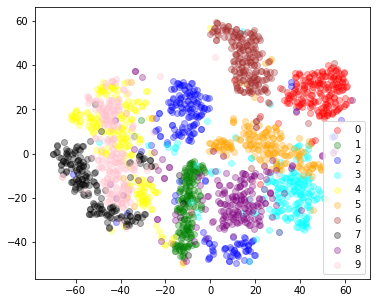

In [14]:
tsne(x_dev1[:2000], ids_dev1[:2000])

### Tsne by mnist digit indentity, rowspace

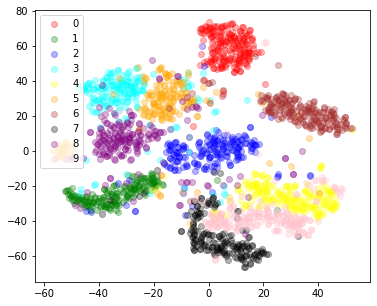

In [26]:
P_rowspace = np.eye(784) - P
tsne(P_rowspace.dot(x_dev1.T).T[:2000], ids_dev1[:2000])

### Tsne by mnist digit indentity, nullspace

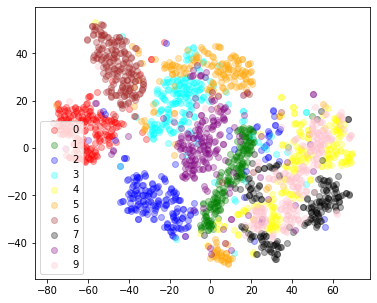

In [27]:
tsne(P.dot(x_dev1.T).T[:2000], ids_dev1[:2000])